# Project

1. Central Idea
    - Idea: We analyze ~18,000 research papers related to Large Language Models and modern AI (LLMs, agentic AI, RAG, foundation models, transformers), downloaded from OpenAlex.
        Our goal is to reveal how ideas evolve in this field, and identify:
        - which topics dominate the field,
        - which papers are most influential,
        - which authors and institutions drive the research.
    - Why interesting? 
    LLMs are evolving extremely fast—every month there is a new architecture, agent framework, or RAG improvement. The public sees hype; we want to see the actual scientific movement.We want to know:
        - Are today's buzzwords (agents, reasoning, RAG) actually backed by science?
        - Who are the “idea hubs” (top-cited papers, institutions)?
        - Which topics are emerging vs. declining?
    - What datasets were explored? How did I download them? We are exploring a dataset of 20000 papers downloaded from OpenAlex. We used the query with parameters large language model|language model|pretrained language model|foundation model|transformer|LLM|agentic AI|AI agent|tool use|retrieval augmented generation|retrieval-augmented|model context protocol), later than 2000 and must have some references. 
2. Total Size of the Data. 17891 json files
    - Papers Citation Graph: 17891 nodes and 54295 edges
    - Co-autors graph: 65931 nodes, 285288 edges
    - Author Citation network: 55431 nodes, 2206140 edges
3. What is the network? - the oens rpesented above 
4. What is the text? The text is the actual text of the papers, and if that is absent we will use the abstract
5. How will text and networks be tied together? The text will be used to determine the most popular terms in the network, build communities and identify which authors defined popular technologies. 

## Papers Citation Graph

#### Network construction
Taking all the json representations of the papers that were queried from OpenAlex.

A node consists from:
- paper_id
- title
- url
- year  
- authors  
- abstract
- topics
- topic
- concepts
- institutions

After analyzing the original network briefly, it was identified that there are a few isolated nodes (they are not cited by anopne and do not cite anyone from the network). It was decided to leave these nodes out and focus on the part of the network that is actually connected. 


In [93]:
import os
import json
import networkx as nx

FOLDER = "papers_full"

Graph = nx.DiGraph()

def extract_id(url):
    if not url:
        return None
    return url.strip().split("/")[-1]

# Load all papers once into memory {paper_id: json_data}
paper_data = {}

print("Loading JSON files...")

for filename in os.listdir(FOLDER):
    if not filename.endswith(".json"):
        continue

    paper_id = filename.replace(".json", "")

    with open(os.path.join(FOLDER, filename), "r", encoding="utf-8") as f:
        data = json.load(f)

    paper_data[paper_id] = data

print(f"Loaded {len(paper_data)} papers")

print("Building graph...")

for paper_id, data in paper_data.items():

    # Convert authors from list -> single string
    authors = ", ".join([a.get("name") for a in data.get("authors", [])])
    # concepts = ", ".join([c.get("name") for c in data.get("concepts", [])])
    # concepts = [c.get("name") for c in data.get("concepts", []) if c.get("name")]
    concepts = data.get("concepts", [])

    institution_list = ", ".join(
        i.get("name") 
        for i in data.get("institutions", [])
        if i.get("name")
        )

    concepts_sorted = sorted(concepts, key=lambda x: x.get("score", 0), reverse=True)

    Graph.add_node(
        paper_id,
        title=str(data.get("title") or ""),
        url = str(data.get("url") or ""),
        year=str(data.get("year") or ""),
        authors=authors,
        abstract=str(data.get("abstract") or ""),  
        topic=str(data.get("topic")),
        concepts = concepts_sorted,
        institutions_flat = institution_list
        # full_text removed (too big + not needed for graph format)
    )

    for ref_url in data.get("references", []):
        ref_id = extract_id(ref_url)
        if ref_id in paper_data:
            Graph.add_edge(paper_id, ref_id)


print("Graph completed.")
print(f"Nodes: {Graph.number_of_nodes()}")
print(f"Edges: {Graph.number_of_edges()}")


Loading JSON files...
Loaded 17891 papers
Building graph...
Graph completed.
Nodes: 17891
Edges: 54295


### Export the graph

In [56]:
# nx.write_gexf(Graph, "papers_citation_graph.gexf")


### General Statistics

In [ ]:
import json
import os
from collections import Counter
### papers per topic
topic_counter = Counter()

for node, attrs in Graph.nodes(data=True):
    topic = attrs.get("topic")
    if topic:
        topic_counter[topic] += 1

print("\n=== Papers per Topic ===")
for topic, count in topic_counter.most_common():
    if count > 10:
        print(f"{topic}: {count}")


=== Papers per Topic ===
Computer science: 5831
Transformer: 1151
Medicine: 285
Perplexity: 176
None: 143
Automatic summarization: 140
Artificial intelligence: 128
Foundation (evidence): 125
Preprint: 110
Interpretability: 103
Generative grammar: 80
Psychology: 76
Segmentation: 76
Dissolved gas analysis: 75
Closed captioning: 65
Biology: 64
Health care: 64
Readability: 63
Context (archaeology): 62
Chatbot: 62
Hyperspectral imaging: 58
Materials science: 57
Question answering: 56
Benchmark (surveying): 53
Convolutional neural network: 53
Inference: 50
Inrush current: 49
Benchmarking: 49
Workflow: 46
Reliability engineering: 45
Partial discharge: 45
Machine translation: 44
Nanofluid: 40
Transformative learning: 39
Leverage (statistics): 39
Converters: 38
Task (project management): 38
Reinforcement learning: 36
Discriminative model: 35
Linguistics: 34
Zhàng: 33
Encoder: 33
Natural language processing: 33
Adversarial system: 31
Transformer oil: 30
Electromagnetic coil: 29
Support vector m

From the original network, it can be seen that even though most papers revolve arounf the COmputer Science topic (around 5.8 k), Transformer (1.15k), there are also those that are of low or no interest to the research of papers focused on the AI, LLM, RAG, agentic AI. 


### Network-Centered Analysis

Constructing a WCC (weakly connected component) in order to keep the directed structure of the network.

Doing this, the nodes that are not conencted to the rest of the graph are eliminated.

What is left is a graph with 14079 nodes out of the original 17891. 

Notice, that this does not mean that the nodes that have been removed do not have any citations at all - they do not have any citations in the network that was constructed here. 

In [94]:
wcc = list(nx.weakly_connected_components(Graph))

gcc_nodes = max(wcc, key=len)

G = Graph.subgraph(gcc_nodes).copy()

print("Nodes in GCC:", len(G))
print("Nodes total:", len(Graph))

Nodes in GCC: 14079
Nodes total: 17891


### Cleaning the network further of useless nodes

In [ ]:
# AI_KEYWORDS = {
#     "Artificial intelligence", "Machine learning", "Deep learning",
#     "Natural language processing", "Transformer", "Language model",
#     "Generative model", "Representation learning", "Neural network",
#     "Question answering"
# }
AI_KEYWORDS = {
    "Artificial intelligence", "Machine learning", "Deep learning",
    "Natural language processing", "Language model",
    "Generative model", "Representation learning", "Neural network",
    "RAG"
}

TOP_N = 5

nodes_to_remove = []

for node, attrs in G.nodes(data=True):
    concepts = attrs.get("concepts", [])

    # Skip if empty
    if not concepts:
        nodes_to_remove.append(node)
        continue

    # Normalize: if stored as strings, wrap into dicts
    if isinstance(concepts[0], str):
        concepts = [{"name": c, "score": 0} for c in concepts]

    # Sort by score (highest relevance first)
    top_concepts = sorted(
        concepts, key=lambda c: c.get("score", 0), reverse=True
    )[:TOP_N]

    # Check relevance in top-N
    matches = any(
        c.get("name") in AI_KEYWORDS
        for c in top_concepts
    )

    if not matches:
        nodes_to_remove.append(node)

print(f"Removing {len(nodes_to_remove)} irrelevant nodes.")
G.remove_nodes_from(nodes_to_remove)

print("Nodes in GCC:", len(G))
print("Nodes total:", len(Graph))

Removing 10401 irrelevant nodes.
Nodes in GCC: 6555
Nodes total: 7490


In [88]:
# Example centrality measures
pagerank = nx.pagerank(G)
degree = dict(G.out_degree())

# Sorted most cited (high indegree)
most_cited = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 most cited papers (by indegree):")
print("########################################")

for paper_id, indeg in most_cited:
    title = G.nodes[paper_id].get("title", "N/A")
    year = G.nodes[paper_id].get("year", "N/A")
    url = G.nodes[paper_id].get("url", "N/A")
    abstract_len = len(G.nodes[paper_id].get("abstract"))
    topic = G.nodes[paper_id].get("topic")
    concepts = G.nodes[paper_id].get("concepts")
    insitutions = G.nodes[paper_id].get("institutions_flat")
    abstract = G.nodes[paper_id].get("abstract")
    cites = G.out_degree(paper_id)
    print(f"{paper_id}, {url}\ntitle: {title}\nyear: {year}\nabstract length: {abstract_len}, topic: {topic},\nconcepts: {concepts}\ninstitutions: {insitutions}\nabstract: {abstract}\ncites: {cites}\n({indeg} citations)")
    print("____________________________________________________________________________________________________________________________________")

least_cited = sorted(G.in_degree(),key = lambda x: x[1], reverse=False)[:5]
print("Top 5 least cited papers (by ind-degree)")
print("########################################")
for paper_id, indeg in least_cited:
    title = G.nodes[paper_id].get("title", "N/A")
    year = G.nodes[paper_id].get("year", "N/A")
    url = G.nodes[paper_id].get("url", "N/A")
    abstract_len = len(G.nodes[paper_id].get("abstract"))
    topic = G.nodes[paper_id].get("topic")
    concepts = G.nodes[paper_id].get("concepts")
    insitutions = G.nodes[paper_id].get("institutions_flat")
    abstract = G.nodes[paper_id].get("abstract")
    cites = G.out_degree(paper_id)
    print(f"{paper_id}, {url}\ntitle: {title}\nyear: {year}\nabstract length: {abstract_len}, topic: {topic},\nconcepts: {concepts}\ninstitutions: {insitutions}\nabstract: {abstract}\ncites: {cites}\n({indeg} citations)")
    print("____________________________________________________________________________________________________________________________________")



Top 5 most cited papers (by indegree):
########################################
W3094502228, https://openalex.org/W3094502228
title: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
year: 2022
abstract length: 854, topic: Image (mathematics),
concepts: ['Image (mathematics)', 'Artificial intelligence', 'Transformer', 'Computer science', 'Computer vision', 'Scale (ratio)', 'Engineering', 'Cartography', 'Electrical engineering', 'Geography', 'Voltage']
institutions: Google (United States), German Research Centre for Artificial Intelligence
abstract: While the Transformer architecture has become the de-facto standard for natural language processing tasks, its applications to computer vision remain limited. In vision, attention is either applied in conjunction with convolutional networks, or used to replace certain components of convolutional networks while keeping their overall structure in place. We show that this reliance on CNNs is not necessary and a pure tra

#### Analyzing the "middle" papers in the network. 
These are the papers that have an average in-degree in relation to the rest of the network. 

In [89]:
# Compute in-degree dict: {node: indegree}
indeg = dict(G.in_degree())

# Compute mean
avg_indeg = sum(indeg.values()) / len(indeg)
print("Average in-degree:", avg_indeg)

# Sort by absolute distance to mean
middle = sorted(indeg.items(), key=lambda x: abs(x[1] - avg_indeg))[:5]

print("\n=== Top 5 Middle Papers (closest to mean in-degree) ===")
for paper_id, val in middle:
    title = G.nodes[paper_id].get("title", "N/A")
    year = G.nodes[paper_id].get("year", "N/A")
    url = G.nodes[paper_id].get("url", "N/A")
    abstract_len = len(G.nodes[paper_id].get("abstract"))
    topic = G.nodes[paper_id].get("topic")
    concepts = G.nodes[paper_id].get("concepts")
    insitutions = G.nodes[paper_id].get("institutions_flat")
    abstract = G.nodes[paper_id].get("abstract")
    cites = G.out_degree(paper_id)
    print(f"{paper_id}, {url}\ntitle: {title}\nyear: {year}\nabstract length: {abstract_len}, topic: {topic},\nconcepts: {concepts}\ninstitutions: {insitutions}\nabstract: {abstract}\ncites: {cites}\n({indeg} citations)")
    print("____________________________________________________________________________________________________________________________________")



Average in-degree: 2.449275362318841

=== Top 5 Middle Papers (closest to mean in-degree) ===
W2131133093, https://openalex.org/W2131133093
title: Using Language Models for Information Retrieval
year: 2001
abstract length: 2509, topic: Information retrieval,
concepts: ['Information retrieval', 'Computer science', 'Natural language processing', 'Artificial intelligence', 'Data science']
institutions: University of Twente
abstract: &lt;p&gt;Because of the world wide web, information retrieval systems are now used by millions of untrained users all over the world. The search engines that perform the information retrieval tasks, often retrieve thousands of potentially interesting documents to a query. The documents should be ranked in decreasing order of relevance in order to be useful to the user. This book describes a mathematical model of information retrieval based on the use of statistical language models. The approach uses simple document-based unigram models to compute for each docu

Discalimer!!!
The citation counts measured represent in-network citations only, not global citation counts. Many highly influential papers cite and are cited by works outside this filtered LLM-focused dataset.


A pre-emptive analysis into most cited and least cited papers was done. 
The most cited papers (with the highest in-degree) in the network that is being analyzed include such titles as 
- "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" from Google (United States) and German Research Centre for Artificial Intelligence from 2022 with the topic of Image (mathematics) analysis. It has 897 citations, being the most cited paper in this network.
- "Chain-of-Thought Prompting Elicits Reasoning in Large Language Models" from 2022 with the topic of Computer Science and 669 citations. It discusses a popular topic in today's AI discussion about Chain-of-Thought
- "Transformers: State-of-the-Art Natural Language Processing" from 2020 with the Art History topic of all things? with 586 citations. The topic assignment seems unusual, but looking into the concepts discussed in the paper it can be seen that it actuyally discusses transformers, computer science, as well as art, natural (archaeology), history, electrical engineering.
- "BioBERT: a pre-trained biomedical language representation model for biomedical text mining" from 2019 from Korea University, Naver (South Korea) with the topic of Biomedical text mining and 495 citations in this network. 
- "Large language models encode clinical knowledge" from 2023 from Google (United States), United States National Library of Medicine, DeepMind (United Kingdom) with the topic of Computer Science and 450 citations. 

The least cited papers in this network have as few as 0 citations. In addition, these papers have very few papers in the ntwork they cite themselves. Most of them cite only 1 other paper in the network and only one cites 4. 

These include:
- "Electromagnetic Modelling of Power Transformers with DC Magnetization" from 2012 with the topic of Transformer. It does not havy any citations but cites one other paper from the network. This paper seems to be irrelevant to the general AI, LLM, RAG domain, as it's topics include Electrical Engineering, Power Transmission, Physics, Power Flow, Voltage.
- "Superconducting Transformer Design and Construction" from 2020 with the topic of Transformer again. And again the concepts it discusses are related to Electrical Engineering, rather than AI & LLM. 
This suggests a pattern that the term "Transformer" in the original search query to OpenAlex.org may also refer to the field of Electrical Engineering rather than Transformer Models on which the modern LLMs are built. 
- "Use Of Hidden Markov Models And Factored Language Models For Automatic Chord Recognition" from 2018 from Fondazione Bruno Kessler with the topic of Hidden Markov model. It discusses the topics of Hidden Markov model, computer science, Language Model, Artificial intelligence, Markov Chain, NLP, etc. It is not cited by anyone in the network, and has only 1 other paper it references. 
- "Combining Language and Vision with a Multimodal Skip-gram Model" from 2015 with the topic of n-gram. Discusses the topics of n-gram, computer science, NLP, Artificail Intelligence, Question Answering, Language Model, Linguistics, etc. No citations and one reference to another paper in the network. 
- "Disentangling the Social and the Pedagogical in Infants' Learning about Tool‐Use" from 2011 with the topic of Psychology. This is another example of an "intruder" due to the "tool use" element in the query made to OpenAlex, as it discusses the infant's response to pedagogy in the domain of tool use. . 


To be fair, the most cited papers in the network sometimes also have few papers in the netwrok they cite themselves. The numbers vary between 1, 7, and 11. This means that these papers actually cite papers that are outside of the network at hand. To comapre, the papers that cite others the most have as many as 99, 82, 74, 72, and 71 respectively.  


Having discussed the two extremes - most cited vs least cited, it may also be interesting too see which papers are in the middle so to speak.

#### Out-Degree

In [68]:
### top 5 papers referencing others
most_citing = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 most cited papers (by indegree):")
print("########################################")

for paper_id, outdeg in most_citing:
    title = G.nodes[paper_id].get("title", "N/A")
    year = G.nodes[paper_id].get("year", "N/A")
    url = G.nodes[paper_id].get("url", "N/A")
    abstract_len = len(G.nodes[paper_id].get("abstract"))
    topic = G.nodes[paper_id].get("topic")
    concepts = G.nodes[paper_id].get("concepts")
    insitutions = G.nodes[paper_id].get("institutions_flat")
    abstract = G.nodes[paper_id].get("abstract")
    cites = G.out_degree(paper_id)
    print(f"{paper_id}, {url}\ntitle: {title}\nyear: {year}\nabstract length: {abstract_len}, topic: {topic},\nconcepts: {concepts}\ninstitutions: {insitutions}\nabstract: {abstract}\ncites: {cites}\n({outdeg} citations)")
    print("____________________________________________________________________________________________________________________________________")

Top 5 most cited papers (by indegree):
########################################
W4388691863, https://openalex.org/W4388691863
title: Language Model Behavior: A Comprehensive Survey
year: 2023
abstract length: 999, topic: Computer science,
concepts: ['Computer science', 'Pragmatics', 'Language model', 'Syntax', 'Natural language processing', 'Artificial intelligence', 'Semantics (computer science)', 'Transformer', 'Linguistics', 'Programming language', 'Physics', 'Quantum mechanics', 'Philosophy', 'Voltage']
institutions: University of California, San Diego
abstract: Abstract Transformer language models have received widespread public attention, yet their generated text is often surprising even to NLP researchers. In this survey, we discuss over 250 recent studies of English language model behavior before task-specific fine-tuning. Language models possess basic capabilities in syntax, semantics, pragmatics, world knowledge, and reasoning, but these capabilities are sensitive to specific

### General Statistics


=== Papers per Topic ===
Computer science: 5831
Transformer: 1151
Medicine: 285
Perplexity: 176
None: 143
Automatic summarization: 140
Artificial intelligence: 128
Foundation (evidence): 125
Preprint: 110
Interpretability: 103
Generative grammar: 80
Psychology: 76
Segmentation: 76
Dissolved gas analysis: 75
Closed captioning: 65
Biology: 64
Health care: 64
Readability: 63
Context (archaeology): 62
Chatbot: 62
Hyperspectral imaging: 58
Materials science: 57
Question answering: 56
Benchmark (surveying): 53
Convolutional neural network: 53
Inference: 50
Inrush current: 49
Benchmarking: 49
Workflow: 46
Reliability engineering: 45
Partial discharge: 45
Machine translation: 44
Nanofluid: 40
Transformative learning: 39
Leverage (statistics): 39
Converters: 38
Task (project management): 38
Reinforcement learning: 36
Discriminative model: 35
Linguistics: 34
Zhàng: 33
Encoder: 33
Natural language processing: 33
Adversarial system: 31
Transformer oil: 30
Electromagnetic coil: 29
Support vector m

### Degree Distribution

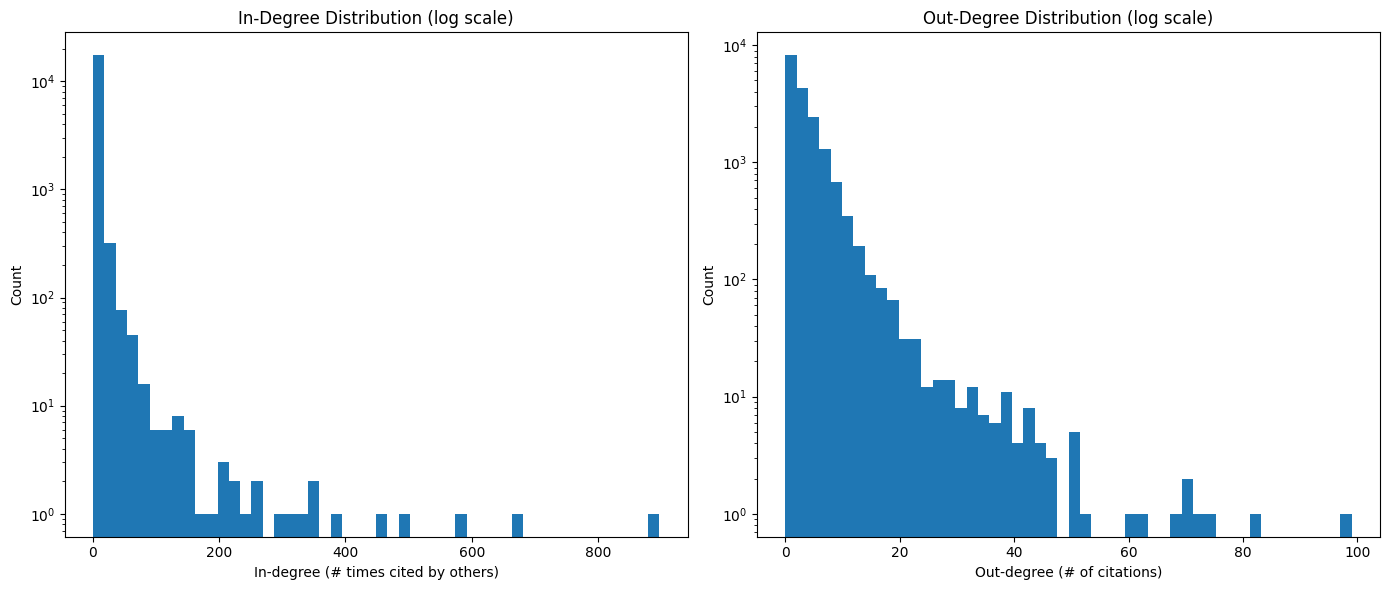

In [12]:
import matplotlib.pyplot as plt

in_degrees = [d for _, d in G.in_degree()]
out_degrees = [d for _, d in G.out_degree()]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=50, density=False)
plt.yscale("log")
plt.title("In-Degree Distribution (log scale)")
plt.xlabel("In-degree (# times cited by others)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=50, density=False)
plt.yscale("log")
plt.title("Out-Degree Distribution (log scale)")
plt.xlabel("Out-degree (# of citations)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


### Co-authorship network

In [ ]:
# import networkx as nx
# import itertools
# import json
# import os

# G = nx.Graph()  # undirected co-authorship network

# for file in os.listdir("papers_full"):
#     if not file.endswith(".json"):
#         continue

#     with open(os.path.join("papers_full", file), encoding="utf-8") as f:
#         data = json.load(f)

#     # Extract only valid author IDs
#     authors = [a.get("id") for a in data.get("authors", []) if a.get("id")]

#     # Skip papers with fewer than 2 authors (no collaboration)
#     if len(authors) < 2:
#         continue

#     # Add authors as nodes
#     for author in authors:
#         G.add_node(author)

#     # Add undirected edges between co-authors
#     for a1, a2 in itertools.combinations(authors, 2):
#         G.add_edge(a1, a2)

# print("Nodes:", G.number_of_nodes())
# print("Edges:", G.number_of_edges())


In [ ]:
# ### Degree distribution of co-authors

# import matplotlib.pyplot as plt

# degrees = [d for _, d in G.degree()]

# plt.figure(figsize=(8, 6))
# plt.hist(degrees, bins=50, density=False)
# plt.yscale("log")
# plt.title("Co-authorship Network Degree Distribution (log scale)")
# plt.xlabel("Degree")
# plt.ylabel("Count")
# plt.show()


### Author Citation Network

In [ ]:
# import networkx as nx
# import os
# import json

# G = nx.DiGraph()

# # Preload all paper data
# papers = {
#     fname[:-5]: json.load(open("papers_full/" + fname, encoding="utf-8"))
#     for fname in os.listdir("papers_full")
#     if fname.endswith(".json")
# }

# for paper_id, data in papers.items():

#     # Extract only valid author IDs
#     authors = [a.get("id") for a in data.get("authors", []) if a.get("id")]

#     for ref_url in data.get("references", []):
#         ref_id = ref_url.split("/")[-1]
#         ref_paper = papers.get(ref_id)

#         if not ref_paper:
#             continue

#         # Extract referenced paper's author IDs (filter out None)
#         ref_authors = [a.get("id") for a in ref_paper.get("authors", []) if a.get("id")]

#         # Create directed edges author → referenced_author
#         for a in authors:
#             for b in ref_authors:
#                 if a and b:  # prevent invalid edges
#                     G.add_edge(a, b)

# print("✅ Author citation network built")
# print(f"Nodes: {G.number_of_nodes()}")
# print(f"Edges: {G.number_of_edges()}")


✅ Author citation network built
Nodes: 55431
Edges: 2206140


In [ ]:
# ### Degree distribution of authors citing each other
# import matplotlib.pyplot as plt

# in_degrees = [d for _, d in G.in_degree()]
# out_degrees = [d for _, d in G.out_degree()]
# plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1)
# plt.hist(in_degrees, bins=50, density=False)
# plt.yscale("log")
# plt.title("Author Citation Network In-Degree Distribution (log scale)")
# plt.xlabel("In-degree (# times cited by other authors)")
# plt.ylabel("Count")
# plt.subplot(1, 2, 2)
# plt.hist(out_degrees, bins=50, density=False)
# plt.yscale("log")
# plt.title("Author Citation Network Out-Degree Distribution (log scale)")
# plt.xlabel("Out-degree (# times citing other authors)")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.show()

# nx.write_gexf(G, "author_citation_network.gexf")